In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_parquet('../data/collected/Paris_pois.zstd')
X = np.array(df[['Latitude', 'Longitude']])
# Reduces classes to 1 for each poi
y = df['Custom'].map(lambda x: x[0])

# Dont use since haversine distance 
# scaler=StandardScaler()
# X=scaler.fit_transform(X)

classes = np.unique(y)
X_class=[]
n_classes = len(classes)

# Each class number of data points
for cls in classes:
    X_cls = X[y == cls]
    X_class.append(X_cls)
    print(X_cls.shape)

(4192, 2)
(14372, 2)
(1457, 2)
(1149, 2)
(302, 2)
(217, 2)
(3599, 2)
(133878, 2)
(1884, 2)
(1981, 2)
(9, 2)
(3341, 2)


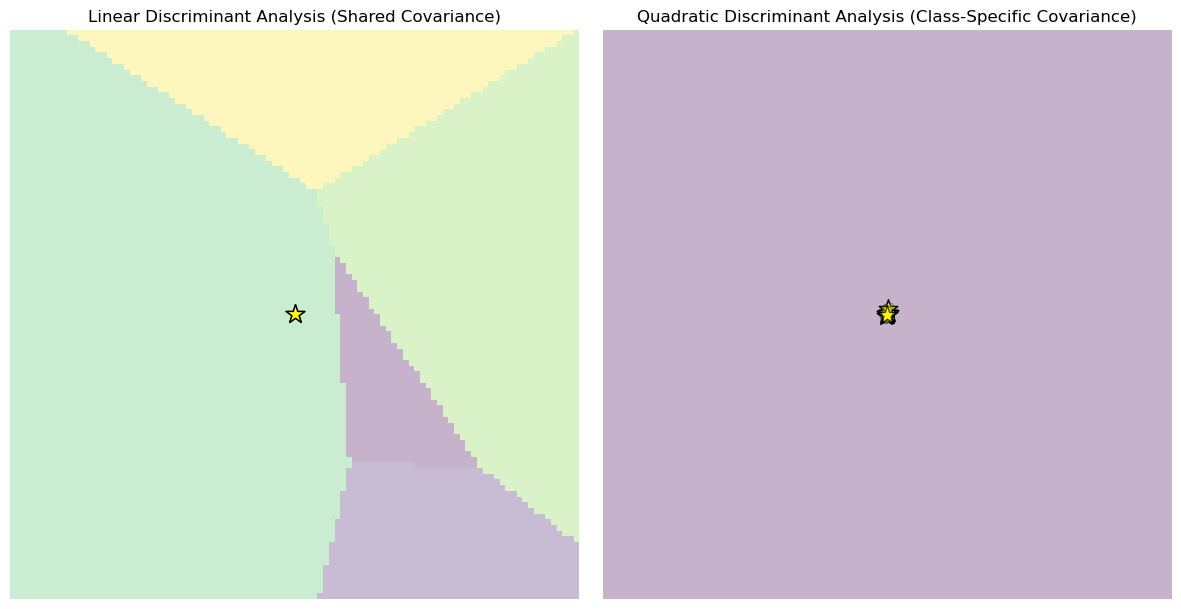

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.patches import Ellipse

def plot_ellipse(mean, cov, color, ax, alpha=0.3):
    """Plot an ellipse representing a 2D Gaussian distribution"""
    v, w = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(w[0, 1], w[0, 0]))
    width, height = 2 * np.sqrt(v)
    ell = Ellipse(
        mean,
        width,
        height,
        angle=angle,
        facecolor=color,
        edgecolor='black',
        alpha=alpha,
        linewidth=1
    )
    ax.add_patch(ell)

def plot_result_multiclass(estimator, X, y, ax):
    cmap = plt.get_cmap('viridis', n_classes)  # Use a colormap with 13 distinct colors
    
    # Plot decision boundaries (using predict instead of predict_proba for multiclass)
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="predict",
        plot_method="pcolormesh",
        ax=ax,
        cmap=cmap,
        alpha=0.3,
    )
    
    # Scatter plot of correct and incorrect predictions
    y_pred = estimator.predict(X)
    correct = y == y_pred
    incorrect = ~correct
    
    # ax.scatter(
    #     X[correct, 0], X[correct, 1],
    #     c=y[correct], cmap=cmap, s=20, alpha=0.7
    # )
    # ax.scatter(
    #     X[incorrect, 0], X[incorrect, 1],
    #     c=y[incorrect], cmap=cmap, s=40, marker='x', alpha=1.0
    # )
    
    # Plot class means and ellipses
    for i, (mean, cov) in enumerate(zip(estimator.means_, estimator.covariance_ if isinstance(estimator, LinearDiscriminantAnalysis) else estimator.covariance_)):
        color = cmap(i / (n_classes - 1))
        ax.scatter(
            mean[0], mean[1],
            c='yellow', s=200, marker='*', edgecolor='black'
        )
        
        # Plot ellipse (only for QDA if using class-specific covariances)
        if isinstance(estimator, QuadraticDiscriminantAnalysis):
            plot_ellipse(mean, cov, color, ax)
    
    ax.set_box_aspect(1)
    ax.set(xticks=[], yticks=[])
    ax.spines[["top", "bottom", "left", "right"]].set_visible(False)

class_means = [] # mean coordiantes for each class
class_covs = []  # cov(lat,long) for each class

for X_cls in X_class:
    class_means.append(np.mean(X_cls, axis=0))
    class_covs.append(np.cov(X_cls.T))

print(X.shape)
print(y.shape)
print(class_means)
print(class_covs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# LDA (assumes shared covariance)
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X, y)
plot_result_multiclass(lda, X, y, ax1)
ax1.set_title("Linear Discriminant Analysis (Shared Covariance)")

# QDA (class-specific covariances)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X, y)
plot_result_multiclass(qda, X, y, ax2)
ax2.set_title("Quadratic Discriminant Analysis (Class-Specific Covariance)")

plt.tight_layout()
plt.show()

c:\Users\PC\Anaconda3\envs\dwvproj\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\PC\Anaconda3\envs\dwvproj\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\PC\Anaconda3\envs\dwvproj\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\PC\Anaconda3\envs\dwvproj\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

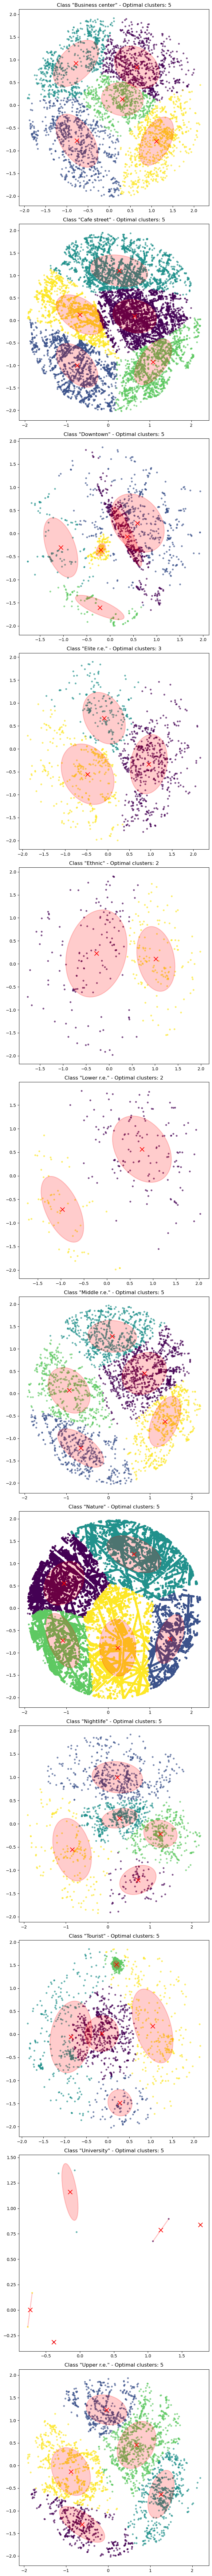

In [ ]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

# Process each class separately
fig, axes = plt.subplots(nrows=n_classes, figsize=(7, 7*n_classes), squeeze=False)

for idx, X_cls in enumerate(X_class):
    axes = axes[idx, 0]
    label=classes[idx]

    # Fit GMM (using BIC to determine optimal components)
    n_components = np.arange(1, 6)
    models = [GaussianMixture(n, covariance_type='full').fit(X_cls) for n in n_components]
    bic = [m.bic(X_cls) for m in models]
    best_n = n_components[np.argmin(bic)]
    
    # Fit best model
    gmm = GaussianMixture(n_components=best_n, covariance_type='full')
    gmm.fit(X_cls)
    labels = gmm.predict(X_cls)
    
    # Plot results
    axes.scatter(X_cls[:, 0], X_cls[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
    axes.set_title(f'Class "{label}" - Optimal clusters: {best_n}')
    
    # Plot ellipses for each component
    for n in range(best_n):
        mean = gmm.means_[n]
        cov = gmm.covariances_[n]
        
        v, w = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(w[0][1], w[0][0]))
        width, height = 2 * np.sqrt(v)
        
        ellipse = Ellipse(mean, width, height, angle=angle, 
                         color='red', alpha=0.2, lw=2)
        axes.add_patch(ellipse)
        axes.scatter(mean[0], mean[1], marker='x', color='red', s=100)

plt.tight_layout()
plt.show()

Business center {'method': 'optics', 'params': {'min_samples': 5, 'xi': 0.05, 'max_eps': 0.4, 'metric': 'euclidean'}}
Cafe street {'method': 'hdbscan', 'params': {'min_cluster_size': 10, 'min_samples': 5, 'cluster_selection_epsilon': 0, 'metric': 'haversine'}}
Downtown {'method': 'optics', 'params': {'min_samples': 7, 'xi': 0.1, 'metric': 'euclidean'}}
Elite r.e. {'method': 'hdbscan', 'params': {'min_cluster_size': 8, 'min_samples': 3, 'cluster_selection_epsilon': 0.1, 'metric': 'haversine'}}
Ethnic {'method': 'spectral', 'params': {'n_clusters': 6, 'affinity': 'nearest_neighbors', 'n_neighbors': 10}}
Lower r.e. {'method': 'hdbscan', 'params': {'min_cluster_size': 20, 'min_samples': 6, 'cluster_selection_epsilon': 0, 'metric': 'haversine'}}
Middle r.e. {'method': 'hdbscan', 'params': {'min_cluster_size': 15, 'min_samples': 5, 'cluster_selection_epsilon': 0.05, 'metric': 'haversine'}}
Nature {'method': 'kmeans', 'params': {'n_clusters': 5, 'random_state': 42}}
Nightlife {'method': 'gmm'

c:\Users\PC\Anaconda3\envs\dwvproj\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\Anaconda3\envs\dwvproj\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


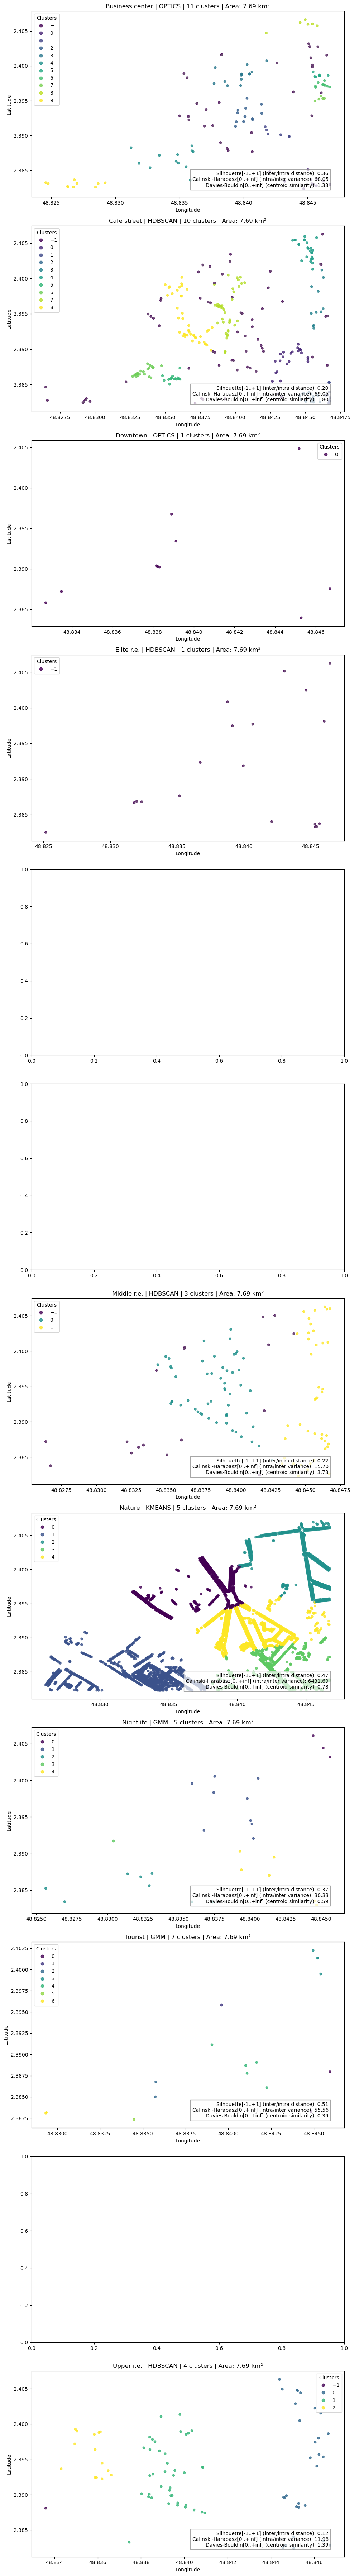

In [18]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from sklearn.cluster import KMeans, OPTICS,SpectralClustering,AffinityPropagation,HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 6371 * 2 * asin(sqrt(a))

with open('../src/clustering.yaml') as f:
    config = yaml.safe_load(f)
fig, axes = plt.subplots(nrows=len(classes), figsize=(10, 6*len(classes)))

# choose area
# Take subset of neighbouring data
random_long=np.random.uniform(X[:,0].min(),X[:,0].max())
random_lat=np.random.uniform(X[:,1].min(),X[:,1].max())
max_lat=X[:,1].max()-X[:,1].min()
random_half_diagonal=np.random.uniform(max_lat/16,max_lat/8)
# take center+-random_half_diagonal subset
lat_min = random_lat - random_half_diagonal
lat_max = random_lat + random_half_diagonal
long_min = random_long - random_half_diagonal
long_max = random_long + random_half_diagonal

# Area in km^2
width_km = haversine(long_min, random_lat, long_max, random_lat)
height_km = haversine(random_long, lat_min, random_long, lat_max)
area_km2 = width_km * height_km

for idx, (X_cls, label) in enumerate(zip(X_class, classes)):
    ax = axes[idx] if len(classes) > 1 else axes
    technique = config['clustering_techniques'].get(label)
    print(label,technique)
        
    # Take subset of values from current class
    mask = ((X_cls[:,0] >= long_min) & (X_cls[:,0] <= long_max) & 
            (X_cls[:,1] >= lat_min) & (X_cls[:,1] <= lat_max))
    X_subset = X_cls[mask]
    
    if len(X_subset) < 10:
        continue
        
    # Apply clustering
    if technique['method'] == 'kmeans':
        model = KMeans(**technique['params']).fit(X_subset)
        labels = model.labels_
    elif technique['method'] == 'optics':
        model = OPTICS(**technique['params']).fit(X_subset)
        labels = model.labels_
    elif technique['method'] == 'hdbscan':
        model = HDBSCAN(**technique['params']).fit(X_subset)
        labels = model.labels_
    elif technique['method'] == 'spectral':
        model = SpectralClustering(**technique['params']).fit(X_subset)
        labels = model.labels_
    elif technique['method'] == 'gmm':
        model = GaussianMixture(**technique['params']).fit(X_subset)
        labels = model.predict(X_subset)
    elif technique['method'] == 'affinity':
        model = AffinityPropagation(**technique['params']).fit(X_subset)
        labels = model.labels_
        
    if len(np.unique(labels))!=1:
        sil_score = silhouette_score(X_subset, labels)
        ch_score = calinski_harabasz_score(X_subset, labels)
        db_score = davies_bouldin_score(X_subset, labels)
    
        metrics_text = (
        f"Silhouette[-1..+1] (inter/intra distance): {sil_score:.2f}\n"
        f"Calinski-Harabasz[0..+inf] (intra/inter variance): {ch_score:.2f}\n"
        f"Davies-Bouldin[0..+inf] (centroid similarity): {db_score:.2f}"
        )
        
        # Add text box to plot
        ax.text(0.95, 0.05, metrics_text,
            transform=ax.transAxes,
            ha='right', va='bottom',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    
    # Visualization
    scatter = ax.scatter(X_subset[:,0], X_subset[:,1], c=labels, 
                        cmap='viridis', s=20, alpha=0.8)
    
    if -1 in labels:  # Noise points
        ax.scatter(X_subset[labels==-1,0], X_subset[labels==-1,1],
                  c='gray', s=10, alpha=0.3, label='Noise')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f"{label} | {technique['method'].upper()} | {len(np.unique(labels))} clusters | Area: {area_km2:.2f} km²")
    ax.legend(*scatter.legend_elements(), title='Clusters')

plt.tight_layout()
plt.show()